# MLG - Walmart Classification
Brought to you by Zhijing Wu

## Preparation and Overview

### Business Understanding

Walmart strives for making better understanding and services to their customers consistently from both artistic and scientific approach. One of their methods to make such effort is to segment the store into different sections according to possible trip types, in order to improve shopping experiences for its customers.
 
Walmart believes that this is the best shopping experience for every customer, because the customers can access their demands regardless of leisurely going through their shopping lists or a short trip for instant needs. The company has started combining the existing customer insights and the purchase history data to decide the trip types for the customers. Because such project is meant to optimize the isle placement in store and not to predict what the customers would buy, there is no real-time data employment needed in the model, which means there is no deployment and our model is for offline analysis only.
 
I intend to upgrade such project, which aims to focus on the classifying customer trips using only a transactional dataset of the items purchased by the customers recently. I will be improving the science behind trip type, and the classification of trip type will help Walmart refine its classic segmentation process. Consequently, the items will be placed in the area in accordance to the trip type with which it is most attached.
 
### Data Understanding
Here is a list of the data features contained in our dataset.
 
1) TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
 
2) VisitNumber - an id corresponding to a single trip by a single customer
 
3) Weekday - the weekday of the trip

4) Upc - the UPC number of the product purchased
 
5) ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
 
6) DepartmentDescription - a high-level description of the item's department
 
7) FinelineNumber - a more refined category for each of the products, created by Walmart
 
The trip types have been categorized into 38 distinct types using a proprietary method applied to an extended set of data. I intend to recreate this categorization/clustering with optimization and logistic regression algorithms, and each customer would be given exactly one trip type prediction. I believe these methods could provide new and more robust ways to categorize trips, and then helping to improve customer shopping experiences at Walmart.
 
### References:
https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

In [1]:
#import statements
import pandas as pd
import numpy as np
import re 
import warnings
warnings.filterwarnings(action="ignore")

from zipfile import ZipFile
from sklearn import svm, tree
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load and preview training data with Zipfile package
file = ZipFile('train.csv.zip', mode = 'r')
train = file.open('train.csv')
train = pd.read_csv(train)
df = train
df.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [4]:
# basic DataFrame info using .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [5]:
# show missing values in original data
print(pd.isnull(df).sum(),'\n')

# show proportion of missing data with respect to the total amount of data
print((pd.isnull(df).sum() / df.shape[0])*100,'\n')

# Removing redundency in department description column
df['DepartmentDescription'].unique()
df = df.replace('MENS WEAR','MENSWEAR')

# are upc and FinelineNumber always missing together? check and see if this is true

print("% of upc and FinelineNumber values missing together:")
print((df.Upc.isnull().sum() / df.FinelineNumber.isnull().sum())*100,'\n')

# what are the values of dept when upc/FinelineNumber are missing?
print("Departments of missing items:")
print(df.DepartmentDescription[train.Upc.isnull()].unique(),'\n')

# when dept is missing, are both upc and FinelineNumber missing?

dept_null = df.DepartmentDescription.isnull()
# only need to test one of upc and FinelineNumber
print("% of upc/FinelineNumber values missing when dept is missing:")
print((df.Upc[dept_null].isnull().mean()*100))

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64 

TripType                 0.000000
VisitNumber              0.000000
Weekday                  0.000000
Upc                      0.638123
ScanCount                0.000000
DepartmentDescription    0.210338
FinelineNumber           0.638123
dtype: float64 

% of upc and FinelineNumber values missing together:
100.0 

Departments of missing items:
[nan 'PHARMACY RX'] 

% of upc/FinelineNumber values missing when dept is missing:
100.0


In [6]:
# drop NA values
df = df.dropna(how='any')
df

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
...,...,...,...,...,...,...,...
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0


Our data set, in its original form, contains 7 features and 647,054 observations. The features are as follows:

TripType: Each distinct value represents a unique trip type, i.e., the set of circumstances that underlie the customer's trip to a Walmart store. Trip Types could include anything from "weekly grocery trip" to "buying bread (or dinner) on the way home from work." The values in this column are integers, and we don't have a key mapping each integer to a trip rationale, so we will have to work with them without knowing what the numbers actually mean. Although the values are stored as integers, this is a discrete/categorical variable, and it is also our target variable.

VisitNumber: Each distinct value represents a single trip by a Walmart shopper. This is our identifier variable for the dataset we will actually use to train the logistic regression classifier and predict values of TripType. That is, our final dataset will have a number of rows equal to the number of unique values in this column where the TripType is one we choose to predict. (More on that last part in a bit).

Weekday: The day of the week on which the trip to Walmart was made. There are 7 unique values of this variable because this is Walmart, not Chick-fil-a.

Upc: This feature contains the UPC barcode number that identifies products sold in stores. The number consists of a manufacturer number and a product code, as well as an extra digit calculated from the other digits used for inventory management purposes and to protect against data entry (human) errors. This variable contains a plethora of information, but will ultimately be dropped, as we explain later.

ScanCount: The number of a particular item that a customer purchased. For example, 3 represents that the customer bought 3 of whatever item is represented by the value in the Upc column.

Department Description: Walmart breaks its stores up into a number of departments which are mutually exclusive. That is, those products which fall into one department fall into only that department. This variable is a string representing that department.

FinelineNumber: This is a numeric value representing a "product category," a Walmart-created system that places products into more narrow groups than in the Department Description feature.

In [7]:
# slice a sample data with only trip type and department description
Trip_Dep = df[['TripType', 'DepartmentDescription']]
Trip_Dep

# use .crosstab() to get the table shown below, which shows dept on each column and trip type for each row
Trip_Dep = pd.crosstab(index    = df.TripType, 
                       columns  = df.DepartmentDescription, 
                       rownames = ['Trip Type'],
                       colnames = ['Department Description'],
                       margins  = False)

In [8]:
Trip_Dep

Department Description,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
Trip Type,,,,,,,,,,,,,,,,,,,,,
3,2,2,20,5,8,24,4,4,9,0,...,0,0,13,0,6,2,16,2,6,3
4,0,1,3,13,0,7,0,0,0,0,...,0,0,9,0,1,0,2,0,2,0
5,1,16,40,66,25,232,7,15,15,9,...,3,1,97,6,40,16,39,0,19,11
6,1,3,5,23,6,23,2,2,1,0,...,4,1,56,0,13,4,9,0,3,1
7,3,11,31,897,5,75,8,15,6,2,...,330,0,3669,4,29,12,30,3,20,11
8,0,6,56,472,36,1112,6,17,16,6,...,2,0,218,3,50,9,31,9,28,8
9,80,186,889,61,223,164,130,101,273,165,...,0,1,70,57,636,177,661,55,573,282
12,0,0,4,16,14,18,1,1,3,2,...,5,1,17,0,13,2,17,2,65,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


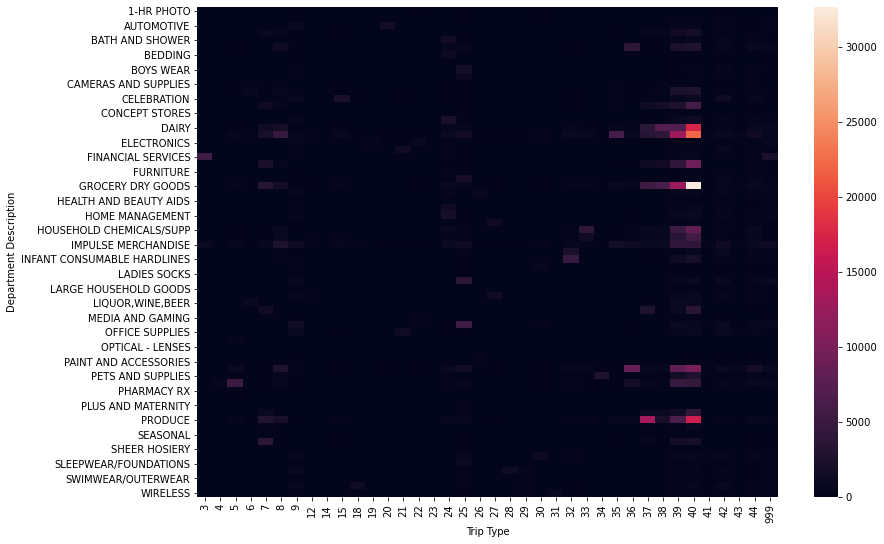

In [9]:
# show a heatmap with triptype and dept descriptions as axis
plt.subplots(figsize=(13,9))
sns.heatmap(Trip_Dep.T)

## Feature Engineering & Data Preparation

In [10]:
# Feature Building by constructing a def with input table called "data"

features = ["Weekday", "NumItems", "Return", 'ACCESSORIES',
       'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
       'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING',  'MENSWEAR',
       'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
       'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
       'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
       'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
       'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
       'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
       'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']

def data_generator(data):
    dummies = pd.get_dummies(df.DepartmentDescription)
    data[dummies.columns] = dummies
    data_dummies = dummies.apply(lambda x: x*data["ScanCount"])

    data.loc[df.ScanCount < 0, 'Return'] = 1
    data.loc[df.ScanCount < 0, 'ScanCount'] = 0
    data.loc[df.Return != 1, 'Return'] = 0

    data = data[["TripType", "VisitNumber", "Weekday", "ScanCount", "Return"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    data = pd.concat([data, data_dummies], axis=1)
    grouped = data.groupby("VisitNumber")
    

    grouped = grouped.agg({'Weekday': np.max, "TripType": np.max, 'NumItems': np.sum, 'Return': np.max,
                                 '1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum, 'AUTOMOTIVE': np.sum, 
                                 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
                                 'BOOKS AND MAGAZINES': np.sum,'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum, 
                                 'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum, 
                                 'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 
                                 'DSD GROCERY': np.sum, 'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 
                                 'FINANCIAL SERVICES': np.sum, 'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 
                                 'GIRLS WEAR, 4-6X  AND 7-14': np.sum, 'GROCERY DRY GOODS': np.sum,
                                 'HARDWARE': np.sum, 'HEALTH AND BEAUTY AIDS': np.sum, 'HOME DECOR': np.sum,
                                 'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
                                 'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
                                 'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 
                                 'INFANT CONSUMABLE HARDLINES': np.sum, 'JEWELRY AND SUNGLASSES': np.sum,
                                 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,'LARGE HOUSEHOLD GOODS': np.sum, 
                                 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum, 
                                 'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum,'MENSWEAR': np.sum,
                                 'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
                                 'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
                                 'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
                                 'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
                                 'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 
                                 'SHEER HOSIERY': np.sum, 'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 
                                 'SPORTING GOODS': np.sum, 'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})

    data = grouped[["TripType", "Weekday", "NumItems", "Return",'1-HR PHOTO', 'ACCESSORIES',
                    'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
                    'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
                    'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
                    'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
                    'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
                    'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
                    'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR',
                    'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
                    'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
                    'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
                    'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
                    'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
                    'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
                    'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
                    'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
                    'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
                    'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
                    'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
                    'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
                    'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]
    return data

# def add_category_counts(data):
#     alist = []
#     for array in np.asarray(data.iloc[:,4:]):
#         count = 0
#         for item in array:
#              if item > 0:
#                 count += 1
#         alist.append(count)
#     cat_counts = pd.DataFrame(alist)
#     cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
#     cat_counts = cat_counts.set_index(data.index)
#     data.insert(4, 'CategoryCounts', cat_counts)
#     return data

df = data_generator(df)
df.shape

(94247, 71)

Text(0.5, 1.0, 'Trip Type')

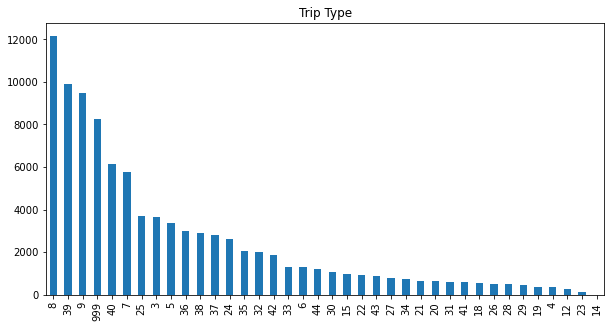

In [11]:
#ploting the bar chart for the trip types 
x = df.TripType
x = x.value_counts()
graph = x.plot(kind="bar", figsize=(10, 5))
graph.set_title("Trip Type")

There is a significant class imbalance in terms of predicting object, TripType. So eliminating extremely popular trip types and unpopular trip types to balance classes better.

In [12]:
# show data descriptions and select only the following trip types: 5, 25, 3, 36, 38, 37, 24, 35, 32
df

,TripType,Weekday,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,Friday,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,30,Friday,2,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,26,Friday,29,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,8,Friday,3,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,8,Friday,3,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191343,25,Sunday,9,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,22,Sunday,5,0.0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,1
191345,39,Sunday,17,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print(df.TripType.isin([5, 25, 3, 36, 38, 37, 24, 35, 32]))


VisitNumber
5         False
7         False
8         False
9         False
10        False
          ...  
191343     True
191344    False
191345    False
191346    False
191347    False
Name: TripType, Length: 94247, dtype: bool


In [14]:
df = df[df.TripType.isin([5, 25, 3, 36, 38, 37, 24, 35, 32])]
df.describe()

,TripType,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,...,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000
mean,24.557519,7.971423,0.052468,0.001306,0.010563,0.020280,0.076743,0.085577,0.234722,0.054888,...,0.015710,0.000192,0.064721,0.005147,0.045016,0.043211,0.017976,0.014788,0.028308,0.002458
std,13.385487,8.526265,0.222973,0.066160,0.142963,0.209009,0.393476,0.798115,1.035118,0.461824,...,0.176234,0.016396,0.352884,0.134264,0.305593,0.375683,0.195359,0.194148,0.249924,0.058745
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,38.000000,313.000000,1.000000,7.000000,7.000000,10.000000,12.000000,67.000000,45.000000,18.000000,...,7.000000,2.000000,8.000000,10.000000,12.000000,18.000000,12.000000,8.000000,10.000000,4.000000


In [15]:
# show the mean of bottom 20 least popular departments
df.mean().sort_values().head(20)

HEALTH AND BEAUTY AIDS     0.000038
CONCEPT STORES             0.000077
OTHER DEPARTMENTS          0.000115
SEASONAL                   0.000192
CAMERAS AND SUPPLIES       0.000576
1-HR PHOTO                 0.001306
PLAYERS AND ELECTRONICS    0.001767
WIRELESS                   0.002458
LARGE HOUSEHOLD GOODS      0.002919
OPTICAL - LENSES           0.003342
SHEER HOSIERY              0.005147
BOOKS AND MAGAZINES        0.006683
MEDIA AND GAMING           0.006722
PHARMACY RX                0.006799
ELECTRONICS                0.007413
PAINT AND ACCESSORIES      0.008258
ACCESSORIES                0.010563
HORTICULTURE AND ACCESS    0.010716
LADIES SOCKS               0.011792
PLUS AND MATERNITY         0.012022
dtype: float64

In [16]:
df.mean().sort_values()[:21]

HEALTH AND BEAUTY AIDS     0.000038
CONCEPT STORES             0.000077
OTHER DEPARTMENTS          0.000115
SEASONAL                   0.000192
CAMERAS AND SUPPLIES       0.000576
1-HR PHOTO                 0.001306
PLAYERS AND ELECTRONICS    0.001767
WIRELESS                   0.002458
LARGE HOUSEHOLD GOODS      0.002919
OPTICAL - LENSES           0.003342
SHEER HOSIERY              0.005147
BOOKS AND MAGAZINES        0.006683
MEDIA AND GAMING           0.006722
PHARMACY RX                0.006799
ELECTRONICS                0.007413
PAINT AND ACCESSORIES      0.008258
ACCESSORIES                0.010563
HORTICULTURE AND ACCESS    0.010716
LADIES SOCKS               0.011792
PLUS AND MATERNITY         0.012022
FURNITURE                  0.014557
dtype: float64

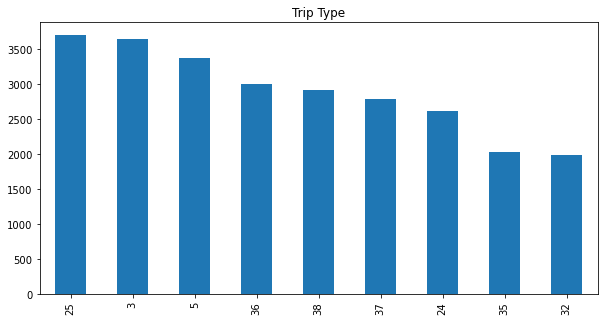

In [17]:
#ploting the bar chart with filtered trip types 
df.TripType.value_counts().plot(kind="bar", figsize=(10, 5), title = "Trip Type")
#graph.set_title("Trip Type")

Text(0.5, 1.0, 'Daywise Visits per Week')

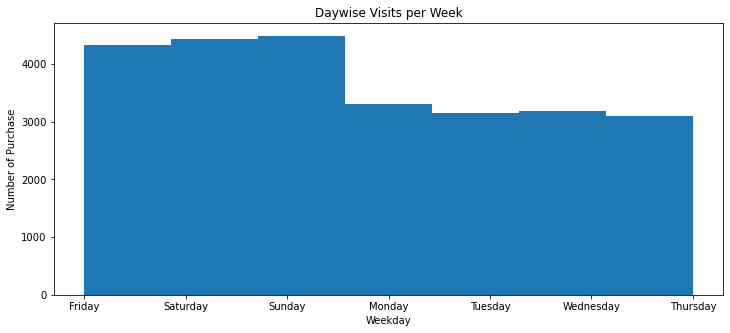

In [18]:
# ploting histogram for daywise visits
#data_tripwd = train_data.drop_duplicates("VisitNumber")
plt.figure(figsize = (12, 5))
n, bins, patches = plt.hist(df.Weekday, 7)
plt.xlabel('Weekday')
plt.ylabel('Number of Purchase')
plt.title('Daywise Visits per Week')

In [19]:
# Use label encoder to .fit_transform() weekday to numbers
# df['Weekday'] = df['Weekday'].map({"Monday": 1, 
#                                    "Tuesday": 2, 
#                                    "Wednesday": 3, 
#                                    "Thursday": 4, 
#                                    "Friday": 5,
#                                    "Saturday": 6, 
#                                    "Sunday": 7})
label_encoder = LabelEncoder()
df.Weekday = label_encoder.fit_transform(df.Weekday)
df

,TripType,Weekday,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
11,35,0,4,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,25,0,8,0.0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
43,38,0,4,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,35,0,5,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,36,0,5,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191326,38,3,11,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191329,24,3,20,0.0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
191335,32,3,9,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test & Train Split

In [20]:
newdf = df.drop(['TripType',
         'HEALTH AND BEAUTY AIDS',
         'CONCEPT STORES',
         'OTHER DEPARTMENTS',
         'SEASONAL',
         'CAMERAS AND SUPPLIES',
         '1-HR PHOTO'],
       axis = 1)
newdf

,Weekday,NumItems,Return,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,PRODUCE,SEAFOOD,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
11,0,4,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,8,0.0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,4,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,5,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,5,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191326,3,11,0.0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
191329,3,20,0.0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191335,3,9,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Data preprocesssing dropping na and splitting data into test and train without the following departments: 
# 'TripType','HEALTH AND BEAUTY AIDS','CONCEPT STORES','OTHER DEPARTMENTS','SEASONAL','CAMERAS AND SUPPLIES','1-HR PHOTO'
df = df.dropna()
newdf2 = newdf.values
X_train, X_test, y_train, y_test = train_test_split(newdf2, df.TripType, test_size=0.2, random_state=999)
X_train

array([[ 2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 5., 32.,  0., ...,  0.,  0.,  0.],
       [ 5.,  5.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 6., 11.,  0., ...,  0.,  0.,  0.],
       [ 2.,  4.,  0., ...,  0.,  0.,  0.],
       [ 0., 17.,  0., ...,  0.,  0.,  0.]])

In [22]:
# show data shape
print(X_train.shape, "\n")
print(y_train.shape, "\n")
print(X_test.shape, "\n")
print(y_test.shape, "\n")

(20828, 64) 

(20828,) 

(5207, 64) 

(5207,) 



## Modeling

#### Logistic Regression

Logistic regression is named for the function used at the core of the method, the logistic function. Logistic regression models the probabilities for classification problems with two possible outcomes. It's an extension of the linear regression model for classification problems.

The logistic function, also called the sigmoid function was developed by statisticians to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment. It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

#### Logistic Regression (a.k.a. logit, MaxEnt) classifier

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to 'ovr', and uses the cross-entropy loss if the 'multi_class' option is set to 'multinomial'. (Currently the 'multinomial' option is supported only by the 'lbfgs', 'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. Note that regularization is applied by default. It can handle both dense and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit floats for optimal performance; any other input format will be converted (and copied).

The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization with primal formulation, or no regularization. The 'liblinear' solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the 'saga' solver.

### Supervised Learning - Logistic Regression

#### Accuracy of Logistic Regression

In [23]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
prediction = lr.predict(X_test)

print("The accuracy of Logistic Regression prediction is", 
      '{:.2%}'.format(accuracy_score(y_test,prediction)))

The accuracy of Logistic Regression prediction is 89.34%


#### Log Loss of Logistic Regression

In [24]:
np.unique(prediction)

array([ 3,  5, 24, 25, 32, 35, 36, 37, 38])

In [25]:
# one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_test_onehot = one_hot.fit_transform(y_test.reshape(-1,1))
# X_test_onehot = one_hot.fit_transform(X_test)
#prediction2 = lr.predict(X_train)

In [26]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test,lr.predict_proba(X_test))))

The log loss of Logistic Regression prediction is 0.42


#### Confusion Matrix on Logistic Regression

In [27]:
pd.crosstab(index    = y_test,
            columns  = prediction, 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,726,1,1,1,1,0,0,0,0
5,1,607,5,2,1,4,22,6,5
24,3,10,425,10,1,8,12,7,9
25,2,8,1,724,3,5,6,9,7
32,1,3,3,7,339,9,10,2,14
35,0,8,3,4,2,325,6,13,32
36,4,37,11,14,6,6,527,6,9
37,1,6,9,2,2,15,3,486,33
38,1,10,10,4,3,47,15,33,493


#### Classification Report on Logistic Regression

In [28]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.88      0.93      0.90       653
          24       0.91      0.88      0.89       485
          25       0.94      0.95      0.94       765
          32       0.95      0.87      0.91       388
          35       0.78      0.83      0.80       393
          36       0.88      0.85      0.86       620
          37       0.86      0.87      0.87       557
          38       0.82      0.80      0.81       616

    accuracy                           0.89      5207
   macro avg       0.89      0.89      0.89      5207
weighted avg       0.89      0.89      0.89      5207



C=1.00
Sparsity with L1 penalty:                2.08%
Sparsity with Elastic-Net penalty:       0.69%
Sparsity with L2 penalty:                0.00%
Score with L1 penalty:                   0.86
Score with Elastic-Net penalty:          0.86
Score with L2 penalty:                   0.86 

The accuracy of Logistic Regression L1 CV prediction is 85.88% 

The log loss of Logistic Regression prediction is 0.67 

              precision    recall  f1-score   support

           3       0.92      0.97      0.95       730
           5       0.84      0.90      0.87       653
          24       0.88      0.76      0.81       485
          25       0.92      0.89      0.90       765
          32       0.95      0.79      0.87       388
          35       0.75      0.82      0.78       393
          36       0.84      0.85      0.85       620
          37       0.84      0.85      0.84       557
          38       0.79      0.81      0.80       616

    accuracy                           0.86     

C=0.00
Sparsity with L1 penalty:                94.97%
Sparsity with Elastic-Net penalty:       93.40%
Sparsity with L2 penalty:                0.00%
Score with L1 penalty:                   0.78
Score with Elastic-Net penalty:          0.81
Score with L2 penalty:                   0.84 

The accuracy of Logistic Regression L1 CV prediction is 78.72% 

The log loss of Logistic Regression prediction is 1.1 

              precision    recall  f1-score   support

           3       0.84      0.98      0.91       730
           5       0.81      0.82      0.82       653
          24       0.80      0.46      0.58       485
          25       0.74      0.79      0.76       765
          32       0.96      0.71      0.82       388
          35       0.73      0.75      0.74       393
          36       0.76      0.84      0.80       620
          37       0.75      0.81      0.78       557
          38       0.76      0.78      0.77       616

    accuracy                           0.79    

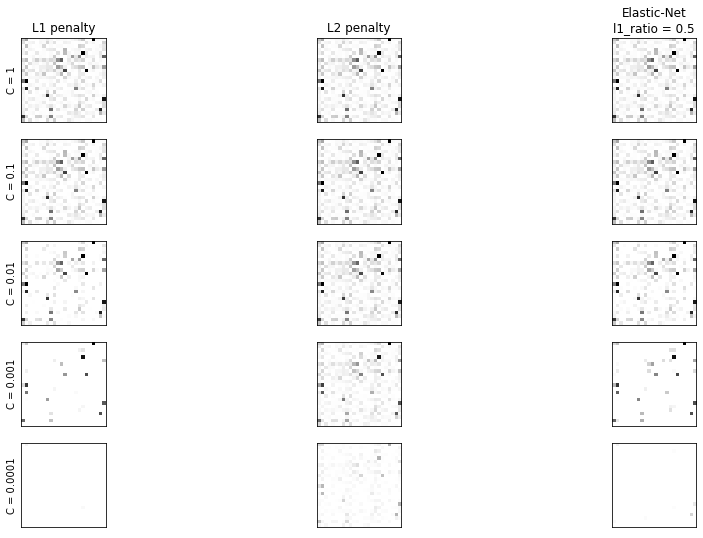

CPU times: user 1min 16s, sys: 812 ms, total: 1min 17s
Wall time: 1min 22s


In [29]:
%%time

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 9))

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01, 0.001, 0.0001), axes)):
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='saga')
    clf_en_LR = LogisticRegression(C=C, penalty='elasticnet', solver='saga',
                                   l1_ratio=l1_ratio, tol=0.01)
    
    clf_l1_LR = clf_l1_LR.fit(X_train, y_train)
    clf_l2_LR = clf_l2_LR.fit(X_train, y_train)
    clf_en_LR = clf_en_LR.fit(X_train, y_train)
    
    predictl1 = clf_l1_LR.predict(X_test)
    predictl2 = clf_l2_LR.predict(X_test)
    predicten = clf_en_LR.predict(X_test)
    
    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:",
                                  sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:",
                                 clf_l1_LR.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:",
                                 clf_en_LR.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(X_train, y_train)), '\n')
    
    
    print("The accuracy of Logistic Regression L1 CV prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, predictl1)), '\n')
          
    print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, clf_l1_LR.predict_proba(X_test))), '\n') 
    print(classification_report(y_test, predictl1), '\n')
          
    print("The accuracy of Logistic Regression L1 CV prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, predictl2), '\n'))
    print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, clf_l2_LR.predict_proba(X_test))), '\n')
    print(classification_report(y_test, predictl2), '\n')
          
    print("The accuracy of Logistic Regression L1 CV prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, predicten), '\n'))
    print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, clf_en_LR.predict_proba(X_test))), '\n')
    print(classification_report(y_test, predicten), '\n')
    
    
    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("L2 penalty")
        axes_row[2].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_l2_LR, coef_en_LR]):
        ax.imshow(np.abs(coefs.reshape((24, 24))), 
                  interpolation='nearest',
                  cmap='binary', vmax=1, vmin=0)
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel('C = %s' % C)

plt.show()

### Grid search Cross Validation to select best params
#### Logistic (Lasso) Regression with Cross Validation

In [33]:
%%time

# use various C values to run the model
cvalues = [float(x) for x in [10, 5, 1, 0.1, 0.01, 0.001]]
lr1cv = LogisticRegressionCV(Cs=cvalues, penalty='l1',solver='saga',multi_class='multinomial')
lr1cv.fit(np.asarray(X_train),np.asarray(y_train))
prediction2 = lr1cv.predict(np.asarray(X_test))

CPU times: user 5min 37s, sys: 1.96 s, total: 5min 39s
Wall time: 5min 51s


#### Accuracy of Logistic (Lasso) Regression with Cross Validation

In [34]:
print("The accuracy of Logistic Regression L1 CV prediction is", 
      '{:.2%}'.format(accuracy_score(np.asarray(y_test),np.asarray(prediction2))))
print("The best Lambda for each class is", lr1cv.C_)

The accuracy of Logistic Regression L1 CV prediction is 88.80%
The best Lambda for each class is [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [35]:
lr1cv.C_

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#### Log Loss of Logistic Regression

In [36]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(np.asarray(y_test),np.asarray(lr1cv.predict_proba(np.asarray(X_test))))))

The log loss of Logistic Regression prediction is 0.46


#### Confusion Matrix on Logistic (Lasso) Regression with Cross Validation

In [37]:
pd.crosstab(index    = np.asarray(y_test),
            columns  = np.asarray(prediction2), 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,727,1,0,1,0,0,1,0,0
5,1,607,5,3,1,5,20,6,5
24,5,14,405,13,1,11,15,11,10
25,1,15,3,704,4,7,12,11,8
32,2,4,4,7,335,11,10,2,13
35,0,9,3,3,1,323,5,14,35
36,3,35,10,13,6,6,530,6,11
37,1,8,10,2,2,12,5,489,28
38,1,10,8,4,3,40,15,31,504


#### Classification Report on Logistic (Lasso) Regression with Cross Validation

In [38]:
print(classification_report(np.asarray(y_test), np.asarray(prediction2)))

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       730
           5       0.86      0.93      0.90       653
          24       0.90      0.84      0.87       485
          25       0.94      0.92      0.93       765
          32       0.95      0.86      0.90       388
          35       0.78      0.82      0.80       393
          36       0.86      0.85      0.86       620
          37       0.86      0.88      0.87       557
          38       0.82      0.82      0.82       616

    accuracy                           0.89      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207



#### Logistic (Ridge) Regression with Cross Validation

In [39]:
%%time

# use various C values to run the model
cvalues = [float(x) for x in [10, 5, 1, 0.1, 0.01, 0.001]]
lr2cv = LogisticRegressionCV(Cs=cvalues, penalty='l2',solver='saga',multi_class='multinomial')
lr2cv.fit(np.asarray(X_train),np.asarray(y_train))
prediction_l2 = lr2cv.predict(np.asarray(X_test))

CPU times: user 3min 22s, sys: 278 ms, total: 3min 22s
Wall time: 3min 22s


#### Accuracy of Logistic (Ridge) Regression with Cross Validation

In [46]:
print("The accuracy of Logistic Regression L2 CV prediction is", 
      '{:.2%}'.format(accuracy_score(np.asarray(y_test),np.asarray(prediction_l2))))
print("The best Lambda for each class is", lr2cv.C_)

The accuracy of Logistic Regression L2 CV prediction is 88.80%
The best Lambda for each class is [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


#### Log Loss of Logistic Regression

In [48]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(np.asarray(y_test),np.asarray(lr2cv.predict_proba(np.asarray(X_test))))))

The log loss of Logistic Regression prediction is 0.46


#### Confusion Matrix on Logistic (Ridge) Regression with Cross Validation

In [52]:
pd.crosstab(index    = np.asarray(y_test),
            columns  = np.asarray(prediction_l2), 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,727,1,0,1,0,0,1,0,0
5,1,605,6,2,1,5,22,6,5
24,5,14,406,12,1,11,15,11,10
25,1,14,3,706,4,7,11,11,8
32,2,4,3,7,336,11,10,2,13
35,0,9,3,3,1,323,5,14,35
36,3,35,12,14,6,6,528,6,10
37,1,8,10,2,2,12,5,489,28
38,1,10,8,4,3,40,15,31,504


#### Classification Report on Logistic (Ridge) Regression with Cross Validation

In [53]:
print(classification_report(np.asarray(y_test), np.asarray(prediction_l2)))

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       730
           5       0.86      0.93      0.89       653
          24       0.90      0.84      0.87       485
          25       0.94      0.92      0.93       765
          32       0.95      0.87      0.91       388
          35       0.78      0.82      0.80       393
          36       0.86      0.85      0.86       620
          37       0.86      0.88      0.87       557
          38       0.82      0.82      0.82       616

    accuracy                           0.89      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207



The linear regression model can work well for regression, but fails for classification. Why is that? In case of two classes, you could label one of the classes with 0 and the other with 1 and use linear regression. Technically it works and most linear model programs will spit out weights for you. But there are a few problems with this approach:

A linear model does not output probabilities, but it treats the classes as numbers (0 and 1) and fits the best hyperplane (for a single feature, it is a line) that minimizes the distances between the points and the hyperplane. So it simply interpolates between the points, and you cannot interpret it as probabilities.

A linear model also extrapolates and gives you values below zero and above one. This is a good sign that there might be a smarter approach to classification.


Since the predicted outcome is not a probability, but a linear interpolation between points, there is no meaningful threshold at which you can distinguish one class from the other. A good illustration of this issue has been given on [Stackoverflow](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression).

Linear models do not extend to classification problems with multiple classes. You would have to start labeling the next class with 2, then 3, and so on. The classes might not have any meaningful order, but the linear model would force a weird structure on the relationship between the features and your class predictions. The higher the value of a feature with a positive weight, the more it contributes to the prediction of a class with a higher number, even if classes that happen to get a similar number are not closer than other classes.

### Supervised Learning - Decision Tree

In [54]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(np.asarray(X_train), np.asarray(y_train))
predict_tree = clf.predict(np.asarray(X_test))

#### Accuracy of Decision Tree

In [55]:
print("The accuracy of Decision Tree prediction is", 
      '{:.2%}'.format(accuracy_score(np.asarray(y_test), np.asarray(predict_tree))))

The accuracy of Decision Tree prediction is 82.66%


#### Log Loss of Decision Tree

In [56]:
print("The log loss of Decision Tree prediction is", 
      '{:.2}'.format(log_loss(np.asarray(y_test), clf.predict_proba(np.asarray(X_test)))))

The log loss of Decision Tree prediction is 5.8


#### Confusion Matrix Decision Tree

In [57]:
pd.crosstab(index    = y_test,
            columns  = predict_tree, 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,723,1,2,1,1,0,1,1,0
5,3,574,11,3,2,6,33,7,14
24,2,8,388,18,3,9,18,18,21
25,1,11,24,654,8,18,21,13,15
32,2,3,10,15,318,7,17,5,11
35,0,13,9,9,3,277,11,23,48
36,3,45,20,26,19,9,472,7,19
37,0,9,11,4,7,25,7,438,56
38,0,12,16,12,8,53,12,43,460


#### Classification Report on Decision Tree

In [58]:
print(classification_report(np.asarray(y_test), np.asarray(predict_tree)))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       730
           5       0.85      0.88      0.86       653
          24       0.79      0.80      0.80       485
          25       0.88      0.85      0.87       765
          32       0.86      0.82      0.84       388
          35       0.69      0.70      0.70       393
          36       0.80      0.76      0.78       620
          37       0.79      0.79      0.79       557
          38       0.71      0.75      0.73       616

    accuracy                           0.83      5207
   macro avg       0.82      0.82      0.82      5207
weighted avg       0.83      0.83      0.83      5207



### Supervised Learning - Random Forest

In [59]:
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(np.asarray(X_train), np.asarray(y_train))
predict_rf = rf.predict(np.asarray(X_test))

#### Accuracy of Random Forest

In [60]:
print("The accuracy of Random Forest prediction is", 
      '{:.2%}'.format(accuracy_score(np.asarray(y_test), np.asarray(predict_rf))))

The accuracy of Random Forest prediction is 88.27%


#### Log Loss of Random Forest

In [61]:
print("The log loss of Random Forest prediction is", 
      '{:.2}'.format(log_loss(np.asarray(y_test), rf.predict_proba(np.asarray(X_test)))))

The log loss of Random Forest prediction is 0.41


#### Confusion Matrix Random Forest

In [62]:
pd.crosstab(index    = y_test,
            columns  = predict_rf, 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,722,1,4,0,1,0,2,0,0
5,2,586,8,3,3,5,28,11,7
24,2,10,418,15,2,2,16,12,8
25,1,5,6,708,7,10,10,10,8
32,1,1,2,10,345,6,12,5,6
35,0,12,5,5,2,307,5,18,39
36,1,31,13,20,7,8,522,11,7
37,0,5,10,1,2,10,4,507,18
38,0,12,10,3,4,43,16,47,481


#### Classification Report on Random Forest

In [63]:
print(classification_report(np.asarray(y_test), np.asarray(predict_rf)))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       730
           5       0.88      0.90      0.89       653
          24       0.88      0.86      0.87       485
          25       0.93      0.93      0.93       765
          32       0.92      0.89      0.91       388
          35       0.79      0.78      0.78       393
          36       0.85      0.84      0.85       620
          37       0.82      0.91      0.86       557
          38       0.84      0.78      0.81       616

    accuracy                           0.88      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.88      0.88      0.88      5207



### Supervised Learning - Support Vector Machine (SVM)

In [64]:
%%time
clf2 = svm.SVC(decision_function_shape='ovr', probability = True)
clf2 = clf2.fit(np.asarray(X_train), np.asarray(y_train))
predict_svm = clf2.predict(np.asarray(X_test))

CPU times: user 1min 48s, sys: 543 ms, total: 1min 49s
Wall time: 1min 50s


#### Accuracy of SVM

In [65]:
print("The accuracy of SVM prediction is", 
      '{:.2%}'.format(accuracy_score(np.asarray(y_test), np.asarray(predict_svm))))

The accuracy of SVM prediction is 88.32%


#### Log Loss of SVM

In [66]:
print("The log loss of SVM prediction is", 
      '{:.2}'.format(log_loss(np.asarray(y_test), clf2.predict_proba(np.asarray(X_test)))))

The log loss of SVM prediction is 0.38


#### Confusion Matrix SVM

In [67]:
pd.crosstab(index    = y_test,
            columns  = predict_svm, 
            rownames = ['Actual'], 
            colnames = ['Predicted'], 
            margins  = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,722,1,0,1,1,0,3,2,0
5,1,597,4,1,2,5,23,12,8
24,6,14,397,11,2,12,18,14,11
25,0,11,5,692,4,11,18,14,10
32,0,2,5,5,336,10,13,4,13
35,0,6,5,3,1,325,7,15,31
36,4,34,8,10,6,6,532,6,14
37,0,8,7,0,3,9,3,492,35
38,0,10,4,3,3,41,15,34,506


#### Classification Report on SVM

In [68]:
print(classification_report(np.asarray(y_test), np.asarray(predict_svm)))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.87      0.91      0.89       653
          24       0.91      0.82      0.86       485
          25       0.95      0.90      0.93       765
          32       0.94      0.87      0.90       388
          35       0.78      0.83      0.80       393
          36       0.84      0.86      0.85       620
          37       0.83      0.88      0.86       557
          38       0.81      0.82      0.81       616

    accuracy                           0.88      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.88      0.88      5207

